In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install torch==1.7.0 torchvision==0.8.1 torchaudio===0.7.0 -f https://download.pytorch.org/whl/cu102/torch_stable.html
!pip install '../input/torch-170-cuda-102/torch-1.7.0-cp37-cp37m-linux_x86_64.whl' --no-deps
!pip install '../input/torch-170-cuda-102/torchvision-0.8.1-cp37-cp37m-linux_x86_64.whl' --no-deps

Processing /kaggle/input/torch-170-cuda-102/torch-1.7.0-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
Processing /kaggle/input/torch-170-cuda-102/torchvision-0.8.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1


In [3]:
!gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# !pip install openmim 
# !mim install mmdet --yes

# v2.18.0

# !rsync -a ../input/mmdetection-v2180/mmdetection/mmdetection ../
# !pip install ../input/mmdetection-v2180/mmdet/mmdet-2.18.0-py3-none-any.whl
# !pip install ../input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
# !pip install ../input/mmdetection-v2180/mmdet/addict-2.4.0-py3-none-any.whl
# !pip install ../input/mmdetection-v2180/mmdet/yapf-0.31.0-py2.py3-none-any.whl
# !pip install ../input/mmdetection-v2180/mmdet/mmcv_full-1.3.16-py2.py3-none-any.whl

# v2.8.0
!rsync -a ../input/mmdetection-v280/mmdetection ../
!pip install ../input/mmdetection-v280/src/mmdet-2.8.0/mmdet-2.8.0/
!pip install ../input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
!pip install ../input/mmdetection-v280/src/addict-2.4.0-py3-none-any.whl
!pip install ../input/mmdetection-v280/src/yapf-0.30.0-py2.py3-none-any.whl
!pip install ../input/mmdetection-v280/src/mmcv_full-1.2.6-cp37-cp37m-manylinux1_x86_64.whl

Processing /kaggle/input/mmdetection-v280/src/mmdet-2.8.0/mmdet-2.8.0
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for mmdet: filename=mmdet-2.8.0-py3-none-any.whl size=502141 sha256=d9a4abcaf0e32a426d282525504d9756fb4c47a00506a4d524b3276be437760a
  Stored in directory: /root/.cache/pip/wheels/ae/ca/90/3616110259678ffe2ef41fd1470981d081a340886954465c71
Successfully built mmdet
Processing /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-featur

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [6]:
# import torch
# import torchvision
from itertools import groupby
from pycocotools import mask as mutils
from pycocotools import _mask as coco_mask
import mmdet
import mmcv
import numpy as np
import cupy as cp
from tqdm.notebook import tqdm
import pandas as pd
import os
import pickle
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt
import base64
import gc
import typing as t
import random
random.seed(42)


In [7]:
# path variables
conf_name = "mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco"
cell_mask_dir = '../input/sartorius-segmentation-mask-npz-dataset/'    
ROOT = '../input/sartorius-cell-instance-segmentation/'
train_or_test = 'train'
img_dir = f'../work/mmdet_{train_or_test}'
!mkdir -p {img_dir}

In [8]:
df = pd.read_csv(f'{ROOT}/train.csv')
df['image_path'] = ROOT + '/train/' + df['id'] + '.png'  # img path
tmp_df = df.drop_duplicates(subset=["id", "image_path"]).reset_index(drop=True)  
tmp_df["annotation"] = df.groupby("id")["annotation"].agg(list).reset_index(drop=True)  # grouping all the annotations that belong to the same id
df = tmp_df.copy()  # overwrite the original df
df['label'] = df.cell_type.map({v:k for k, v in enumerate(df.cell_type.unique())})  # cell labels
display(df.head(2))

debug = False 
if debug:
    df = df[:10]
    

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,image_path,label
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,../input/sartorius-cell-instance-segmentation/...,0
1,0140b3c8f445,[32499 3 33201 7 33902 9 34604 10 35306 11 360...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_F8-3_Vessel-361_Ph_4,0 days 09:00:00,../input/sartorius-cell-instance-segmentation/...,1


In [9]:
# helper function for decoding the rle mask (string formatted) to a numpy array, where 1 = mask and 0 = background
def rle2mask(rle, shape=[520, 704]):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# helper fn for retreiving the masks from a specified image
def get_mask(image_id):
    mask_df   = df[df.id == image_id]
    gt_masks = [rle2mask(rle) for rle in mask_df["annotation"].tolist()[0]]
    gt_masks = np.stack(gt_masks)
    return gt_masks



# helper fn for converting segmentation masks in a specific image, from numpy arrays, to run length encoding
def get_rles_from_mask(image_id):
    mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
    rle_list = []
    mask_ids = np.unique(mask)
    for val in mask_ids:
        if val == 0:
            continue
        binary_mask = np.where(mask == val, 1, 0).astype(bool)
        rle = coco_rle_encode(binary_mask)
        rle_list.append(rle)
    return rle_list, mask.shape[0], mask.shape[1]


# similar to the function above
def get_rles_from_mask2(image_id):

    train2 = train[train["id"] == image_id]
    gt_masks = train2["annotation"].map(rle_decode).tolist()
    gt_masks = np.stack(gt_masks)

    rle_list = []
    for binary_mask in gt_masks:
        rle = coco_rle_encode(binary_mask)
        rle_list.append(rle)
    return rle_list, gt_masks.shape[1], gt_masks.shape[2]


# a direct conversion from mask to rle form
def coco_rle_encode(mask):
    rle = {'counts': [], 'size': list(mask.shape)}
    counts = []
    for i, (value, elements) in enumerate(groupby(mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    rle['counts'] = counts
    return rle

In [10]:
# mmdet custom dataset generator
# returns annotations for custom dataset

def mk_mmdet_custom_data(image_id):
    rles, height, width = get_rles_from_mask(image_id)
    if len(rles) == 0:
        return {
            'filename': image_id +'.png',
            'width': width,
            'height': height,
            'ann': {}
        }
    rles = mutils.frPyObjects(rles, height, width) # converts uncompressed rles to encoded RLE mask
    bboxes = mutils.toBbox(rles) # rle to bbox
    
    # coco bboxes format is  [x y w h]. This changes it to [ymin xmin ymax xmax]
    bboxes[:, 2] += bboxes[:, 0] 
    bboxes[:, 3] += bboxes[:, 1]
    return {
        'filename': image_id + '.png',
        'width': width,
        'height': height,
        'ann':
            {
                'bboxes': np.array(bboxes, dtype=np.float32),
                'labels': np.zeros(len(bboxes)), # dummy data.(will be replaced later)
                'masks': rles
            }
    }

In [11]:
# image augmentation, original image + mask visualization

def print_masked_img(image_id, mask):
    img   = load_RGBY_image(image_id, train_or_test)[...,0]
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img2  = clahe.apply(img)
    img3  = cv2.equalizeHist(img)
    img   = np.stack([img, img2, img3],axis=-1)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask,cmap='inferno')
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4, cmap='inferno')
    plt.title('Image + Mask')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def load_RGBY_image(image_id, train_or_test='train', image_size=None):
    img = read_img(image_id, train_or_test, image_size)
    stacked_images = np.stack([img for _ in range(3)],axis=-1)
    return stacked_images


def read_img(image_id, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.max() > 255:
        img_max = img.max()
        img = (img/255).astype('uint8')
        
    if img.dtype == 'uint16':
        img = (img/256).astype('uint8')
    return img


# make annotation helper called multi processes
# images are annotated and saved onto disk
def mk_ann(idx):
    image_id = df.iloc[idx]['id']
    anno = mk_mmdet_custom_data(image_id)
    img = load_RGBY_image(image_id, train_or_test)
    cv2.imwrite(f'{img_dir}/{image_id}.png', img)
    return anno, idx, image_id

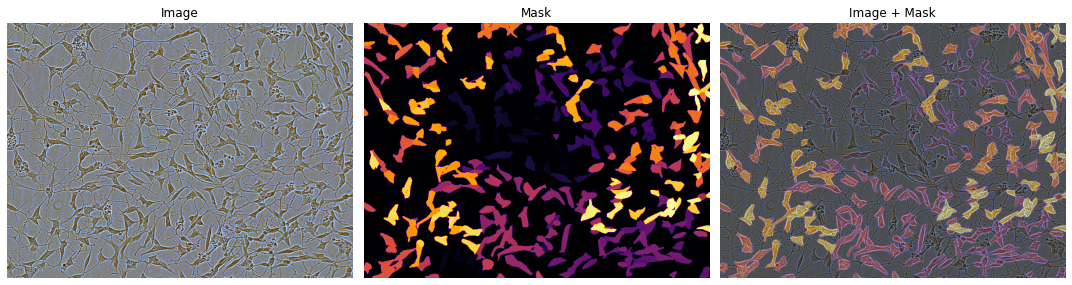

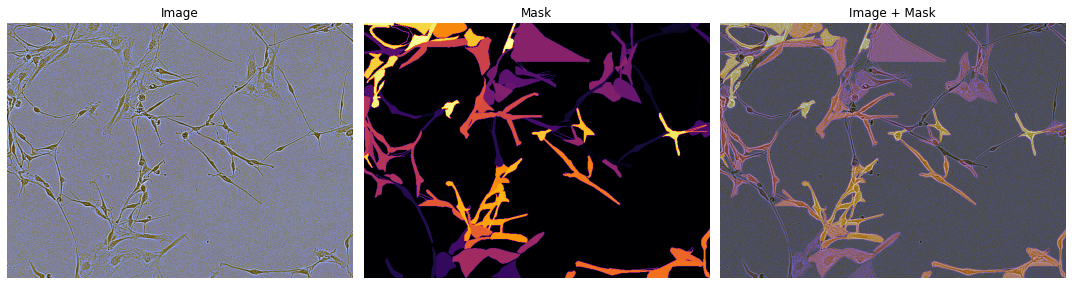

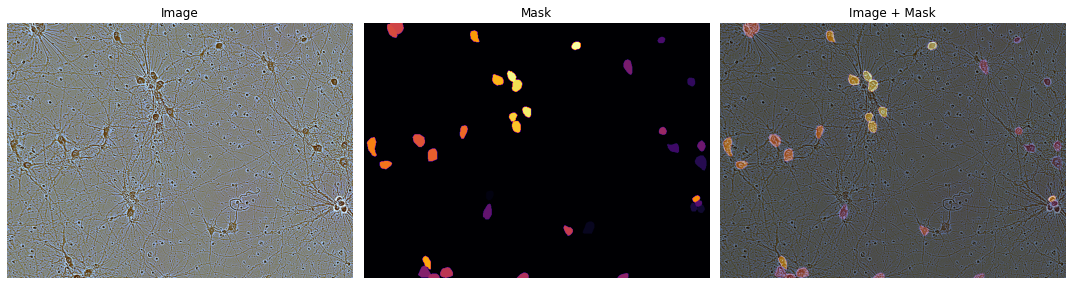

In [12]:
# visuals
for idx in range(3):
    image_id = df.iloc[idx]['id']
    cell_mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
    print_masked_img(image_id, cell_mask)

In [13]:
# make annotations on all images - using the mk_ann helper fn
MAX_THRE = 4 # total CPU
p = Pool(processes=MAX_THRE)
annos = []
len_df = len(df)
# for anno, idx, image_id in tqdm(p.imap(mk_ann, range(len(df))), total=len(df)):
#     if len(anno['ann']) > 0:
#         annos.append(anno)

In [14]:
# train and val annotations split
# lbl_cnt_dict = df.set_index('id').to_dict()['label']
# trn_annos = []
# val_annos = []
# val_len = int(len(annos)*0.01)

# adding all the annotations and appedning them to lists trn_annos and val_annos
# for idx in range(len(annos)):
#     ann = annos[idx]
#     filename  = ann['filename'].replace('.jpg','').replace('.png','')
#     label_ids = [0] 
#     len_ann   = len(ann['ann']['bboxes'])
#     bboxes    = ann['ann']['bboxes']
#     masks     = ann['ann']['masks']

    
#     for cnt, label_id in enumerate(label_ids):
#         label_id = int(label_id)
#         if cnt == 0:
#             ann['ann']['labels'] = np.full(len_ann, label_id)
#         else:
#             ann['ann']['bboxes'] = np.concatenate([ann['ann']['bboxes'],bboxes])
#             ann['ann']['labels'] = np.concatenate([ann['ann']['labels'],np.full(len_ann, label_id)])
#             ann['ann']['masks'] = ann['ann']['masks'] + masks    
#     if idx < val_len:
#         val_annos.append(ann)
#     else:
#         trn_annos.append(ann)

In [15]:
# storing the annotations in the specified paths

# with open(f'../work/mmdet_full.pkl', 'wb') as f:
#     pickle.dump(annos, f)
    
# with open(f'../work/mmdet_trn.pkl', 'wb') as f:
#     pickle.dump(trn_annos, f)
    
# with open(f'../work/mmdet_val.pkl', 'wb') as f:
#     pickle.dump(val_annos, f)

In [16]:
!cp -r /kaggle/input/sartorius-mmdet-config-ds/sartorius /kaggle/mmdetection/configs/sartorius

In [17]:
!ls -l ../mmdetection/configs/sartorius/

total 32
-rw-r--r-- 1 root root  318 Nov 29 23:35 default_runtime.py
-rw-r--r-- 1 root root 3855 Nov 29 23:35 mask_rcnn_r50_fpn.py
-rw-r--r-- 1 root root  116 Nov 29 23:35 mask_rcnn_r50_fpn_1x_coco.py
-rw-r--r-- 1 root root  175 Nov 29 23:35 mask_rcnn_s101_fpn_syncbn-backbone+head_mstrain_1x_coco.py
-rw-r--r-- 1 root root 1960 Nov 29 23:35 mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py
-rw-r--r-- 1 root root 1960 Nov 29 23:35 mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco_1600.py
-rw-r--r-- 1 root root 1716 Nov 29 23:35 sartorius_instance.py
-rw-r--r-- 1 root root  283 Nov 29 23:35 schedule_1x.py


In [18]:
%%writefile /kaggle/mmdetection/configs/sartorius/mask_rcnn_r50_fpn.py

# model settings
model = dict(
    type='MaskRCNN',  # The name of detector
    pretrained='torchvision://resnet50',  
    backbone=dict(  # The backbone config
        type='ResNet', # The type of the backbone,
        depth=50, # The depth of the backbone (usually 50 or 101)
        num_stages=4, # Number of stages of the backbone.
        out_indices=(0, 1, 2, 3),  # The index of output feature maps produced in each stages
        frozen_stages=1, # weights in the first stage are frozen
        norm_cfg=dict(type='BN', requires_grad=True), # normalization layers config.. Type of norm layer, usually it is BN or GN
        norm_eval=True,
        style='pytorch'), # The style of backbone, 'pytorch' means that stride 2 layers are in 3x3 conv, 'caffe' means stride 2 layers are in 1x1 convs.
    neck=dict(  # The neck config
        type='FPN',  # type of neck used by the detector
        in_channels=[256, 512, 1024, 2048], # input channels - consistent with the output channels of the backbone
        out_channels=256, # output channels
        num_outs=5), # no of output scales
    rpn_head=dict(  # RPN config
        type='RPNHead',  # Type of RPNhead
        in_channels=256,  # The input channels of each input feature map, this is consistent with the output channels of neck
        feat_channels=256,  # Feature channels of convolutional layers in the head.
        anchor_generator=dict(  # anchor config
            type='AnchorGenerator',  # Type of anchor. most use this
            scales=[8], # Basic scale of the anchor
            ratios=[0.5, 1.0, 2.0],   # The ratio between height and width.
            strides=[4, 8, 16, 32, 64]),  # The strides of the anchor generator. This is consistent with the FPN feature strides
        bbox_coder=dict(   # Config of box coder to encode and decode the boxes during training and testing
            type='DeltaXYWHBBoxCoder',   # Type of box coder
            target_means=[.0, .0, .0, .0],  # target means used to encode and decode bboxes
            target_stds=[1.0, 1.0, 1.0, 1.0]),  # target standard variance used to encode and decode boxes
         loss_cls=dict(  # loss function config
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0), # Type of loss
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
    roi_head=dict(  # RoIHead encapsulates the second stage of two-stage/cascade detectors.
        type='StandardRoIHead', # Type of the RoI head
        bbox_roi_extractor=dict( # RoI feature extractor for bbox regression
            type='SingleRoIExtractor', # Type of RoI feature extractor
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0), # Config of RoI Layer  # The output size of feature maps.  # Sampling ratio when extracting the RoI features. 0 means adaptive ratio.
            out_channels=256,  # output channels of the extracted feature.
            featmap_strides=[4, 8, 16, 32]),  # Strides of multi-scale feature maps. It should be consistent to the architecture of the backbone.
        bbox_head=dict(   # Config of box head in the RoIHead.
            type='Shared2FCBBoxHead', # Type of the bbox head
            in_channels=256,  # Input channels for bbox head. This is consistent with the out_channels in roi_extractor
            fc_out_channels=1024,   # Output feature channels of FC layers.
            roi_feat_size=7, # Size of RoI features
            num_classes=1, # number of class(es) for classification
            bbox_coder=dict(  
                type='DeltaXYWHBBoxCoder', # Box coder used in the second stage.
                target_means=[0., 0., 0., 0.], # Means used to encode and decode box
                target_stds=[0.1, 0.1, 0.2, 0.2]), # Standard variance for encoding and decoding
            reg_class_agnostic=False, # Whether the regression is class agnostic.
            loss_cls=dict( # Type of loss for classification branch
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0)),  # Config of loss function for the regression branch.
        mask_roi_extractor=dict(   # RoI feature extractor for mask generation.
            type='SingleRoIExtractor',   # Type of the RoI feature extractor
            roi_layer=dict(type='RoIAlign', output_size=14, sampling_ratio=0),   # Config of RoI Layer that extracts features for instance segmentation
            out_channels=256, # Output channels of the extracted feature.
            featmap_strides=[4, 8, 16, 32]),  # Strides of multi-scale feature maps.
        mask_head=dict(  # Mask prediction head
            type='FCNMaskHead',
            num_convs=4, # num of convolutional layers in the mask head
            in_channels=256,  # Input channels, should be consistent with the output channels of mask roi extractor.
            conv_out_channels=256,  # Output channels of the convolutional layer.
            num_classes=1, # number of class(es) to be segmented
            loss_mask=dict(
                type='CrossEntropyLoss', use_mask=True, loss_weight=1.0))))  # Config of loss function for the mask branch.

# model training and testing settings

train_cfg = dict(
    rpn=dict(  # Training config of rpn
        assigner=dict(  # Config of assigner
            type='MaxIoUAssigner',  
            # thresholds
            pos_iou_thr=0.7,
            neg_iou_thr=0.3,
            min_pos_iou=0.3,
            match_low_quality=True,
            ignore_iof_thr=-1),
        sampler=dict(  # Type of sampler
            type='RandomSampler',
            num=256, # num of samples
            pos_fraction=0.5,
            neg_pos_ub=-1,  # thresholds  # The upper bound of negative samples based on the number of positive samples.
            add_gt_as_proposals=False),  # Whether add GT as proposals after sampling.
        allowed_border=-1, # allowed after padding for valid anchors.
        pos_weight=-1,
        debug=False),
    rpn_proposal=dict(  # The config to generate proposals during training
        nms_across_levels=False, 
        nms_pre=2000,
        nms_post=1000,
        max_num=1000,
        nms_thr=0.7,
        min_bbox_size=0),
    rcnn=dict(  # The config for the roi heads.
        assigner=dict(  # Config of assigner for second stage, this is different from that in rpn
            type='MaxIoUAssigner',
            pos_iou_thr=0.5,
            neg_iou_thr=0.5,
            min_pos_iou=0.5,
            match_low_quality=True,  # Whether to match the boxes under low quality
            ignore_iof_thr=-1),
        sampler=dict(
            type='RandomSampler',
            num=512,
            pos_fraction=0.25,
            neg_pos_ub=-1,
            add_gt_as_proposals=True),
        mask_size=28,
        pos_weight=-1,
        debug=False))

test_cfg = dict(
    rpn=dict(
        nms_across_levels=False,
        nms_pre=1000,
        nms_post=1000,
        max_num=1000,
        nms_thr=0.7,
        min_bbox_size=0),
    rcnn=dict(
        score_thr=0.05,
        nms=dict(type='nms', iou_threshold=0.5),
        max_per_img=200,
        mask_thr_binary=0.5))

Overwriting /kaggle/mmdetection/configs/sartorius/mask_rcnn_r50_fpn.py


In [19]:
%%writefile /kaggle/mmdetection/configs/sartorius/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py

# custom config
_base_ = 'mask_rcnn_r50_fpn_1x_coco.py'
norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    pretrained='open-mmlab://resnest50',
    backbone=dict(
        type='ResNeSt', # changed backbone
        stem_channels=64,
        depth=50,
        radix=2,  # Radix of SplitAttentionConv2d
        reduction_factor=4,
        avg_down_stride=True, # average pool for stride in Bottleneck. 
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=norm_cfg,
        norm_eval=False,
        style='pytorch'),
    roi_head=dict(
        bbox_head=dict(
            type='Shared4Conv1FCBBoxHead',
            conv_out_channels=256,
            norm_cfg=norm_cfg),
        mask_head=dict(norm_cfg=norm_cfg)))

# resnest image norm
img_norm_cfg = dict(
    mean=[123.68, 116.779, 103.939], std=[58.393, 57.12, 57.375], to_rgb=True)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='LoadAnnotations',
        with_bbox=True,
        with_mask=True,
        poly2mask=True),
    dict(
        type='Resize',
        img_scale=[(1333, 1333), (1280, 1280), (1024, 1024)],
        multiscale_mode='value',
        keep_ratio=True),
    dict(type='RandomFlip', direction=['horizontal', 'vertical'], flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),
]

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1280, 1280),
        flip=True,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip',direction=['horizontal', 'vertical']),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

data = dict(
    samples_per_gpu=2, # batch_size
    train=dict(pipeline=train_pipeline),
    val=dict(pipeline=test_pipeline),
    test=dict(pipeline=test_pipeline))

Overwriting /kaggle/mmdetection/configs/sartorius/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py


In [20]:
%%writefile /kaggle/mmdetection/configs/sartorius/schedule_1x.py
 
# optimizer
optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)

# learning policy
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[8, 11])

# total epoch count
total_epochs = 20

Overwriting /kaggle/mmdetection/configs/sartorius/schedule_1x.py


In [21]:
# training

config = f'configs/sartorius/{conf_name}.py'    # custom config path
# additional_conf = '--cfg-options'
# additional_conf += f' work_dir=../working/work_dir'
# additional_conf += f' optimizer.lr=0.0025'
# cmd = f'bash -x tools/dist_train.sh {config} 1 {additional_conf}'  # executable shell script  # config arg, # gpu arg, # additional configs args
# !cd ../mmdetection;  {cmd}   # execute

In [22]:
# ls -Rl

*DL Links*

<a href="./work_dir/epoch_10.pth"> epoch 10 </a>
<br>
<a href="./work_dir/epoch_12.pth"> epoch 12 </a>
<br>
<a href="./work_dir/epoch_13.pth"> epoch 13 </a>
<br>
<a href="./work_dir/epoch_16.pth"> epoch 16 </a>
<br>
<a href="./work_dir/epoch_18.pth"> epoch 18 </a>
<br>
<a href="./work_dir/epoch_20.pth"> epoch 20 </a>

In [23]:
from glob import glob

# inference
train_or_test = 'test'
THR = 0.50
test_df = pd.DataFrame(glob(ROOT+f'/{train_or_test}/*'), columns=['image_path'])
test_df['id'] = test_df.image_path.map(lambda x: x.split('/')[-1].split('.')[0])
display(test_df.head())

,image_path,id
0,../input/sartorius-cell-instance-segmentation/...,7ae19de7bc2a
1,../input/sartorius-cell-instance-segmentation/...,d8bfd1dafdc4
2,../input/sartorius-cell-instance-segmentation/...,d48ec7815252


In [24]:
# convert a binary mask into the challenge encoding ASCII text
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    if mask.dtype != np.bool:
        raise ValueError("encode_binary_mask expects a binary mask, recieved dtype == %s"%  mask.dtype)
    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2D mask, received shape == %s"%   mask.shape)
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1) # converting inputs to expected COCO API input format
    mask_to_encode = mask_to_encode.astype(np.int8)
    mask_to_encode = np.asfortranarray(mask_to_encode)
    
# RLE encode mask
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    
    return base64_str.decode()

def mask2rle(msk):
    #returns run length as string format
    msk = cp.array(msk)
    pixels = msk.flatten()
    pad = cp.array([0])
    pixels = cp.concatenate([pad, pixels, pad])
    runs = cp.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [25]:
# !rm -rf out_image_dir

In [26]:
# test image data
out_image_dir = f'../work/mmdet_{train_or_test}/'
!mkdir -p {out_image_dir}

annos = []
for idx in tqdm(range(len(test_df))):
        image_id = test_df.iloc[idx]['id']
        img = load_RGBY_image(image_id, train_or_test)
        
        cv2.imwrite(f'{out_image_dir}/{image_id}.png', img)
        
        ann = {
            'filename': image_id+'.png',
            'width': img.shape[1],
            'height': img.shape[0],
            'ann': {
                'bboxes': None,
                'labels': None,
                'masks': None
            }
        }
        annos.append(ann)

with open(f'../work/mmdet_tst.pkl', 'wb') as f:
          pickle.dump(annos,f)

  0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
!pip install '../input/mmdetection-v2180/mmdet/mmdet/terminaltables-3.1.0/terminaltables-3.1.0'
model_name = 'epoch_16'
model_file = f'../input/scis-train/outputs/{model_name}.pth'
result_pkl = f'../work/{model_name}.pkl'
additional_conf = '--cfg-options'
additional_conf += f' test_cfg.rcnn.score_thr={THR}'
cmd_test = f'python tools/test.py {config} {model_file} --out {result_pkl} {additional_conf}' # test cmd

!cd ../mmdetection; {cmd_test} # infer exec

# inf results
result = pickle.load(open('../mmdetection/'+result_pkl, 'rb'))

Processing /kaggle/input/mmdetection-v2180/mmdet/mmdet/terminaltables-3.1.0/terminaltables-3.1.0
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15354 sha256=4fd638ed64c2a9753870ac02af8e2badec37cbdf4944c7bd153aef774c49d880
  Stored in directory: /root/.cache/pip/wheels/c5/50/08/911e4d234545e8adfbdbf95cc746887db7aaaac760e7cd3d33
Successfully built terminaltables
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 2.4 task/s, elapsed: 1s, ETA:     0s
writing results to ../work/epoch_16.pkl


In [28]:
!ls -l ../work

total 24
-rw-r--r-- 1 root root 10544 Nov 29 23:35 epoch_16.pkl
drwxr-xr-x 2 root root  4096 Nov 29 23:35 mmdet_test
drwxr-xr-x 2 root root  4096 Nov 29 23:35 mmdet_train
-rw-r--r-- 1 root root   250 Nov 29 23:35 mmdet_tst.pkl


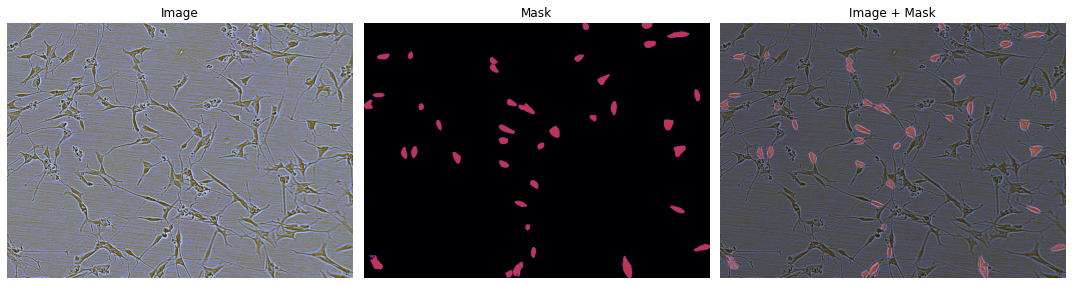

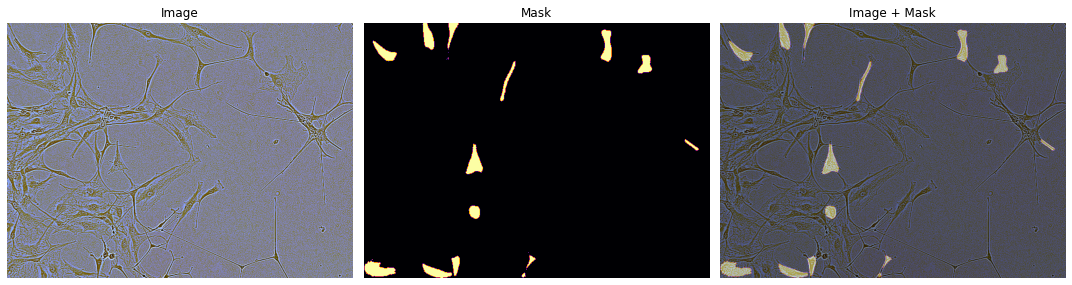

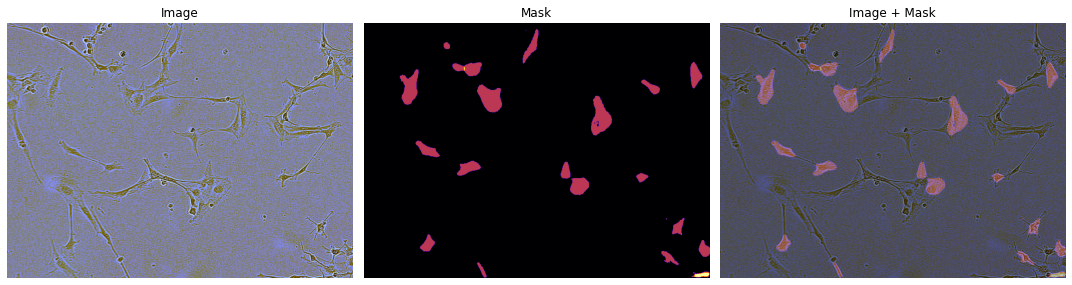

In [29]:
for ii in range(3):
    image_id = annos[ii]['filename'].replace('.jpg','').replace('.png','')
    for class_id in range(1):
        #print(ii,class_id,len(result[ii][0][class_id]), len(result[ii][1][class_id]))
        bbs = result[ii][0][class_id]
        sgs = result[ii][1][class_id]
        for idx, (bb, sg) in enumerate(zip(bbs,sgs)):
            box = bb[:4]
            cnf = bb[4]
            h = sg['size'][0]
            w = sg['size'][0]
            if cnf > 0.1:
#                 print(f'class_id:{class_id}, image_id:{image_id}, confidence:{cnf}')
                if idx==0:
                    mask = mutils.decode(sg)
                else:
                    mask+=mutils.decode(sg)
        print_masked_img(image_id, mask)

In [30]:
# the competition metric checks if the final pairs are sorted, positive, and not duplicated. The predicted pixel values for any two predicted masks should not be overlapping.
# returns
def one_hot(y, num_classes, dtype=cp.uint8):  # GPU
    y = cp.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:  # check if single channel
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
            num_classes = cp.max(y) + 1
    n = y.shape[0]
    categorical = cp.zeros((n, num_classes), dtype=dtype)
    categorical[cp.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = cp.reshape(categorical, output_shape)
    return categorical

# returns multichannel mask with non-overlapping values
def fix_overlap(msk):  # GPU   # multi-channel mask - each channel is an instance of a cell
    msk = cp.array(msk)
    msk = cp.pad(msk, [[0,0],[0,0],[1,0]]) # add dummy mask for background
    ins_len = msk.shape[-1]
    msk = cp.argmax(msk,axis=-1) # convert multi channel mask to single channel mask, argmax will remove overlap
    msk = one_hot(msk, num_classes=ins_len) # back to multi-channel mask, some instance might get removed
    msk = msk[...,1:] # remove background mask
    msk = msk[...,cp.any(msk, axis=(0,1))] # remove all-zero masks
    #assert np.prod(msk, axis=-1).sum()==0 # overlap check, will raise error if there is overlap
    return msk

def check_overlap(msk):
    msk = msk.astype(cp.bool).astype(cp.uint8)
    return cp.any(cp.sum(msk, axis=-1)>1) # only one channel will contain a value

In [31]:
# submission
data = []
for ii in tqdm(range(len(annos))):
    image_id = annos[ii]['filename'].replace('.jpg','').replace('.png','')
    mask = []
    for class_id in range(1):
        bbs = result[ii][0][class_id]
        sgs = result[ii][1][class_id]
        for bb, sg in zip(bbs,sgs):
            box = bb[:4]
            cnf = bb[4]
            h = sg['size'][0]
            w = sg['size'][1]
            #convert coco format to kaggle format
            mask.append(cp.array(mutils.decode(sg)))
        mask = cp.stack(mask, axis=-1)
        if check_overlap(mask): # if mask instances have overlap then fix it
            mask = fix_overlap(mask)
        for idx in range(mask.shape[-1]):
            mask_ins = mask[...,idx]
            rle  = mask2rle(mask_ins)
            data.append([image_id, rle])
        del mask, rle, sgs, bbs
        gc.collect()
pred_df = pd.DataFrame(data, columns=['id','predicted'])


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `cupy.bool` is a deprecated alias for the Python scalar type `bool`. Please use the builtin `bool` or its corresponding NumPy scalar type `cupy.bool_` instead.


In [32]:
pred_df.head()

,id,predicted
0,7ae19de7bc2a,140005 10 140708 18 141411 20 142115 20 142819...
1,7ae19de7bc2a,96419 2 97122 5 97826 6 98529 8 99233 9 99937 ...
2,7ae19de7bc2a,178897 5 179600 6 180304 6 181007 7 181711 7 1...
3,7ae19de7bc2a,177348 10 178046 17 178745 23 179448 24 180151...
4,7ae19de7bc2a,263217 7 263920 11 264624 15 265328 19 266033 ...


In [33]:
sub_df  = pd.read_csv('../input/sartorius-cell-instance-segmentation/sample_submission.csv')
del sub_df['predicted']
sub_df = sub_df.merge(pred_df, on='id', how='left')
sub_df.to_csv('submission.csv',index=False)
sub_df.head()

,id,predicted
0,7ae19de7bc2a,140005 10 140708 18 141411 20 142115 20 142819...
1,7ae19de7bc2a,96419 2 97122 5 97826 6 98529 8 99233 9 99937 ...
2,7ae19de7bc2a,178897 5 179600 6 180304 6 181007 7 181711 7 1...
3,7ae19de7bc2a,177348 10 178046 17 178745 23 179448 24 180151...
4,7ae19de7bc2a,263217 7 263920 11 264624 15 265328 19 266033 ...
